In [1]:
# churn_library.py

"""
Author: Jeremy Gu

For the list of Python (3.10.12) packages and their versions used in this project.
autopep8==2.0.4
joblib==1.3.2
matplotlib==3.8.2
matplotlib-inline==0.1.6
numpy==1.26.3
pandas==2.2.0
pylint==3.0.3
scikit-learn==1.4.0
seaborn==0.13.1
shap==0.44.0
"""

# import libraries
import sys
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, RocCurveDisplay
import os
os.environ['QT_QPA_PLATFORM'] = 'offscreen'
import logging

# Configure logging
logging.basicConfig(
    filename='./results.log',
    level=logging.INFO,
    filemode='w',
    format='%(name)s - %(levelname)s - %(message)s')


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:

# Part 1.
def import_data(pth):
    """
    returns dataframe for the csv found at pth
    input:
        pth: a path to the csv
    output:
        df: pandas dataframe
    """
    logging.info(f"Importing data from {pth}")
    df = pd.read_csv(pth)
    df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)
    logging.info("Data imported successfully and 'Churn' column created.")
    return df


In [3]:
# Part 2.


def perform_eda(df):
    """
    Perform EDA on df and save figures to images/eda folder
    input:
        df: pandas dataframe
    output:
        None
    """
    eda_folder = 'images/eda'
    if not os.path.exists(eda_folder):
        os.makedirs(eda_folder)

    logging.info("Performing Exploratory Data Analysis (EDA)")

    # Histogram of Churn
    plt.figure(figsize=(20, 10))
    df['Churn'].hist()
    plt.savefig(f'{eda_folder}/churn_hist.png')

    # Histogram of Customer Age
    plt.figure(figsize=(20, 10))
    df['Customer_Age'].hist()
    plt.savefig(f'{eda_folder}/customer_age_hist.png')

    # Bar plot of Marital Status
    plt.figure(figsize=(20, 10))
    df['Marital_Status'].value_counts('normalize').plot(kind='bar')
    plt.savefig(f'{eda_folder}/marital_status_bar.png')

    # Distribution plot of Total Transactions Count
    plt.figure(figsize=(20, 10))
    sns.histplot(df['Total_Trans_Ct'], kde=True)
    plt.savefig(f'{eda_folder}/total_trans_ct_dist.png')

    # Heatmap of Correlations
    plt.figure(figsize=(20, 10))
    sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='Dark2_r', linewidths=2)
    plt.savefig(f'{eda_folder}/heatmap.png')

    # Additional Plots
    # Boxplot for Quantitative Features
    plt.figure(figsize=(20, 10))
    df.boxplot(column=['Customer_Age', 'Total_Trans_Ct', 'Credit_Limit'])
    plt.savefig(f'{eda_folder}/quantitative_boxplots.png')

    # Count plot for a Categorical Feature (e.g., Education Level)
    plt.figure(figsize=(20, 10))
    sns.countplot(x='Education_Level', data=df)
    plt.savefig(f'{eda_folder}/education_level_count.png')

    # Pairplot for first few Numeric Features
    plt.figure(figsize=(20, 20))
    sns.pairplot(df[['Customer_Age', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Credit_Limit']])
    plt.savefig(f'{eda_folder}/pairplot.png')

    # Violin Plot for Credit Limit
    plt.figure(figsize=(20, 10))
    sns.violinplot(x='Churn', y='Credit_Limit', data=df)
    plt.savefig(f'{eda_folder}/credit_limit_violin.png')

    logging.info("EDA completed and figures saved in the images/eda folder.")


In [4]:

# Part 3.
def encoder_helper(df, category_lst, response):
    """
    helper function to turn each categorical column into a new column with
    proportion of churn for each category
    input:
        df: pandas dataframe
        category_lst: list of columns that contain categorical features
        response: string of response name [optional argument that could be used for naming variables or index y column]
    output:
        df: pandas dataframe with new columns for
    """
    logging.info("Encoding categorical features.")
    for category in category_lst:
        cat_list = []
        cat_groups = df.groupby(category)[response].mean()

        for val in df[category]:
            cat_list.append(cat_groups.loc[val])

        df[category + '_' + response] = cat_list
    logging.info("Categorical features encoded successfully.")
    return df


In [5]:

# Part 4.
def perform_feature_engineering(df, response):
    """
    input:
        df: pandas dataframe
        response: string of response name [optional argument that could be used for naming variables or index y column]
    output:
        X_train: X training data
        X_test: X testing data
        y_train: y training data
        y_test: y testing data
    """
    logging.info("Performing feature engineering...")

    # Adding encoded columns
    logging.info("Encoding categorical features...")
    df['Gender_Churn'] = df.groupby('Gender')[response].transform('mean')
    df['Education_Level_Churn'] = df.groupby('Education_Level')[response].transform('mean')
    df['Marital_Status_Churn'] = df.groupby('Marital_Status')[response].transform('mean')
    df['Income_Category_Churn'] = df.groupby('Income_Category')[response].transform('mean')
    df['Card_Category_Churn'] = df.groupby('Card_Category')[response].transform('mean')
    
    # Selecting necessary columns
    keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                 'Total_Relationship_Count', 'Months_Inactive_12_mon',
                 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
                 'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
                 'Income_Category_Churn', 'Card_Category_Churn']
    
    X = df[keep_cols]
    y = df[response]

    logging.info("Splitting data into training and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    logging.info("Feature engineering completed.")
    return X_train, X_test, y_train, y_test


In [6]:
# Part 5.
def classification_report_image(rfc_model, lrc_model, X_train, X_test, y_train, y_test):
    """
    Generates and saves classification reports and ROC curve images for trained models.
    input:
        rfc_model: trained random forest classifier
        lrc_model: trained logistic regression classifier
        X_train: training data features
        X_test: test data features
        y_train: training data labels
        y_test: test data labels
    output:
        None
    """
    logging.info("Generating classification reports and ROC curves...")

    # Generate predictions
    y_train_preds_rf = rfc_model.predict(X_train)
    y_test_preds_rf = rfc_model.predict(X_test)
    y_train_preds_lr = lrc_model.predict(X_train)
    y_test_preds_lr = lrc_model.predict(X_test)

    # Generate and save classification report for Random Forest
    plt.rc('figure', figsize=(5, 5))
    plt.text(0.01, 1.25, 'Random Forest Train', {'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.05, classification_report(y_train, y_train_preds_rf), {'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.6, 'Random Forest Test', {'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.7, classification_report(y_test, y_test_preds_rf), {'fontsize': 10}, fontproperties='monospace')
    plt.axis('off')
    plt.savefig('images/rfc_classification_report.png')
    logging.info("Classification report for Random Forest saved.")

    # Generate and save classification report for Logistic Regression
    plt.figure()
    plt.rc('figure', figsize=(5, 5))
    plt.text(0.01, 1.25, 'Logistic Regression Train', {'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.05, classification_report(y_train, y_train_preds_lr), {'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.6, 'Logistic Regression Test', {'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.7, classification_report(y_test, y_test_preds_lr), {'fontsize': 10}, fontproperties='monospace')
    plt.axis('off')
    plt.savefig('images/lrc_classification_report.png')
    logging.info("Classification report for Logistic Regression saved.")

    # Generate and save ROC curve for Logistic Regression
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    lrc_plot = RocCurveDisplay.from_estimator(lrc_model, X_test, y_test, ax=ax, alpha=0.8)
    plt.title('ROC Curve - Logistic Regression')
    plt.savefig('images/lrc_roc_curve.png')
    logging.info("ROC curve for Logistic Regression saved.")

    # Generate and save ROC curve for Random Forest Classifier
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(rfc_model, X_test, y_test, ax=ax, alpha=0.8)
    plt.title('ROC Curve - Random Forest')
    plt.savefig('images/rfc_roc_curve.png')
    logging.info("ROC curve for Random Forest saved.")


In [7]:
# Part 6.


In [31]:
def feature_importance_plot(model, X_data, output_pth):
    """
    Creates and stores the feature importances using traditional method and SHAP values.
    input:
        model: model object containing feature_importances_
        X_data: pandas dataframe of X values
        output_pth: base path to store the figure
    output:
        None
    """
    # Ensure the directory exists
    output_dir = os.path.dirname(output_pth)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    logging.info("Creating and saving traditional feature importance plot.")
    # Traditional feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [X_data.columns[i] for i in indices]

    plt.figure(figsize=(20, 5))
    plt.title("Traditional Feature Importance")
    plt.ylabel('Importance')
    plt.bar(range(X_data.shape[1]), importances[indices])
    plt.xticks(range(X_data.shape[1]), names, rotation=90)
    plt.savefig(f'{output_pth}_traditional.png')

    logging.info(f"Traditional feature importance plot saved in {output_pth}_traditional.png.")
    logging.info("Creating and saving SHAP feature importance plot.")

    # SHAP feature importance
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_data)

    plt.figure(figsize=(10, 8))
    plt.title("SHAP Feature Importance")
    shap.summary_plot(shap_values, X_data, plot_type="bar", show=False)
    plt.savefig(f'{output_pth}_shap.png')

    logging.info(f"SHAP feature importance plot saved in {output_pth}_shap.png.")


In [9]:
# Part 7.
def train_models(X_train, X_test, y_train, y_test):
    """
    train, store model results: images + scores, and store models
    input:
        X_train: X training data
        X_test: X testing data
        y_train: y training data
        y_test: y testing data
    output:
        None
    """
    logging.info("Training models started.")

    # Random Forest Classifier
    logging.info("Training Random Forest Classifier...")
    rfc = RandomForestClassifier(random_state=42)
    param_grid_rfc = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [4, 5, 100],
        'criterion': ['gini', 'entropy']
    }
    logging.info(f"Random Forest parameters: {param_grid_rfc}")
    cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, cv=5)
    cv_rfc.fit(X_train, y_train)
    logging.info("Random Forest training completed.")

    # Logistic Regression Classifier
    logging.info("Training Logistic Regression Classifier...")
    lrc = LogisticRegression(solver='lbfgs', max_iter=3000)
    logging.info(f"Logistic Regression parameters: solver=lbfgs, max_iter=3000")
    lrc.fit(X_train, y_train)
    logging.info("Logistic Regression training completed.")

    # Uncomment if you want to include classification report and feature importance plot
    # classification_report_image(y_train, y_test, y_train_preds_lr, y_train_preds_rf, y_test_preds_lr, y_test_preds_rf)
    # feature_importance_plot(cv_rfc.best_estimator_, X_train, 'images/feature_importance.png')

    logging.info("Training models completed.")

    # Saving models
    logging.info("Saving trained models...")
    joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
    joblib.dump(lrc, './models/logistic_model.pkl')
    logging.info("Models saved.")

    return cv_rfc.best_estimator_, lrc


In [22]:

# Example usage

# Step 1: Data Import and Exploratory Data Analysis
# Importing the data from CSV and performing EDA
df = import_data('./data/bank_data.csv')



When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


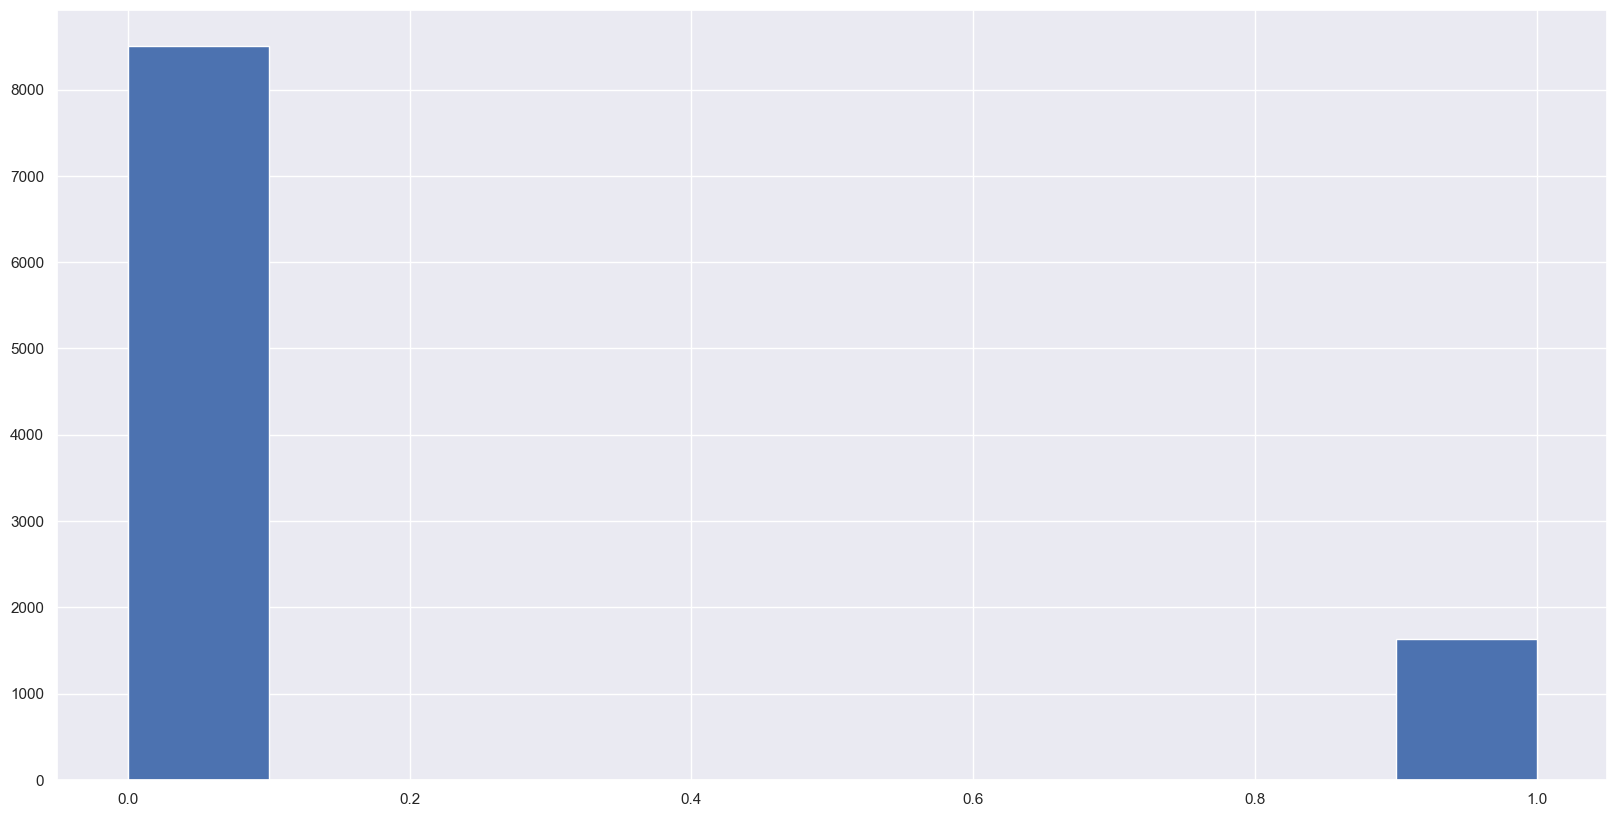

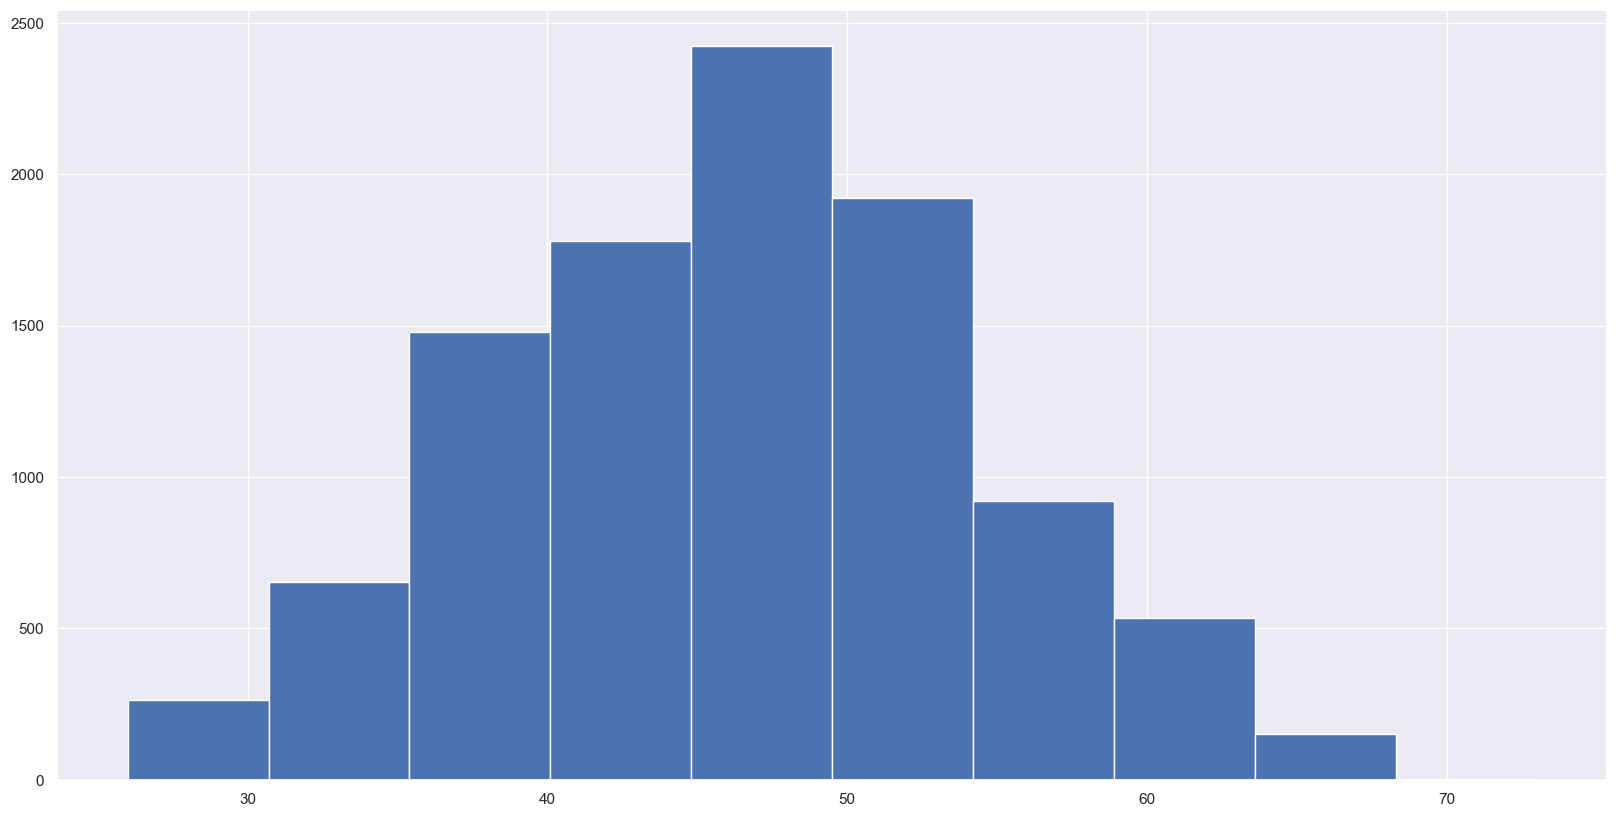

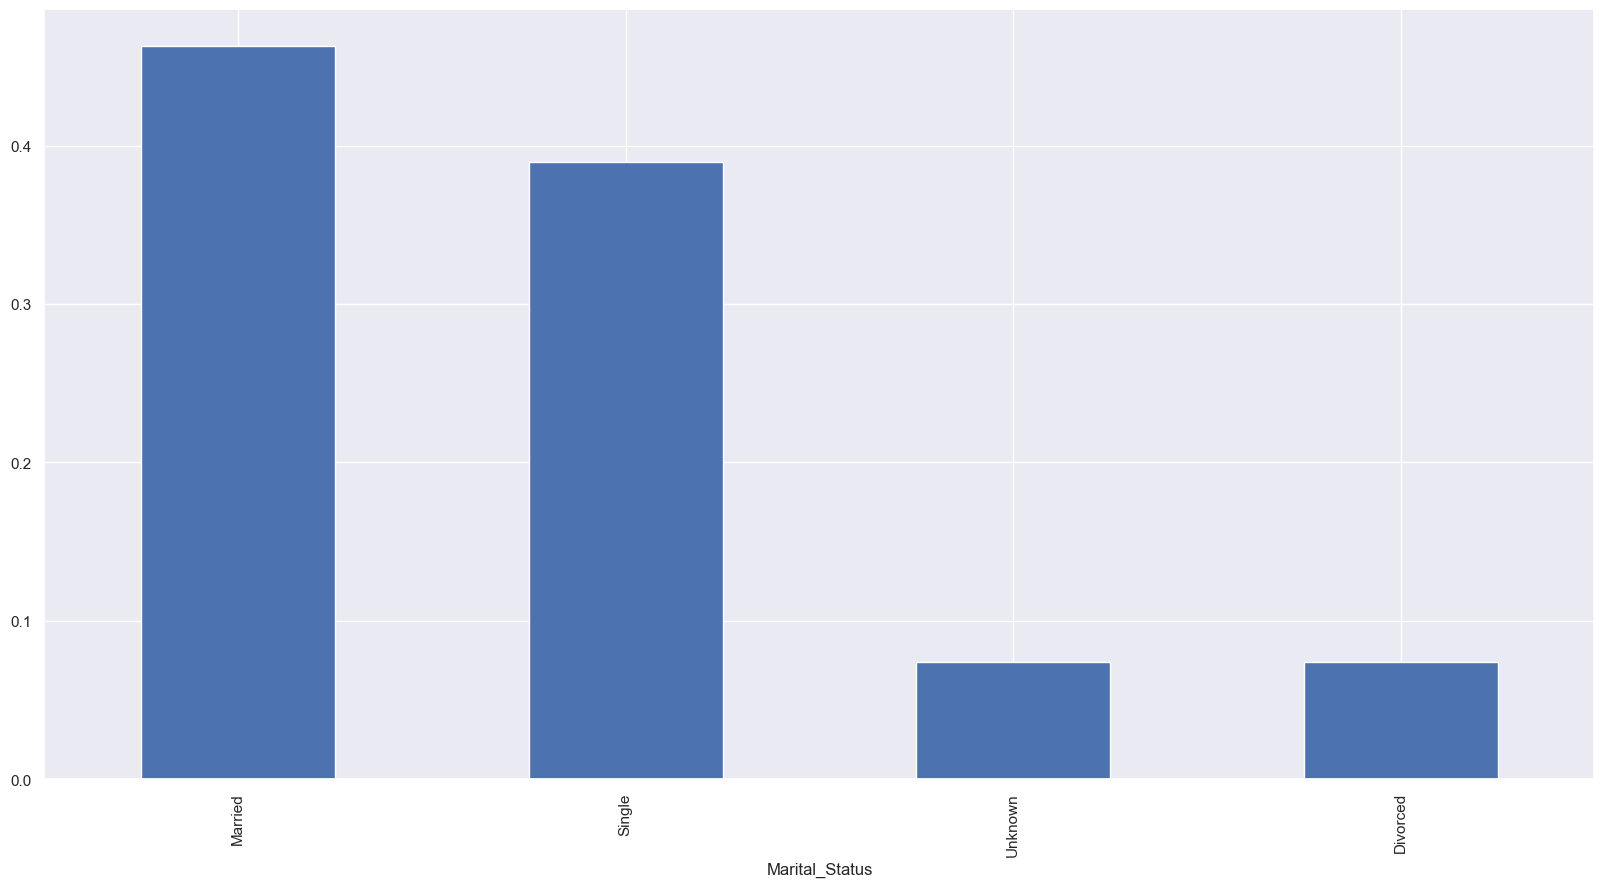

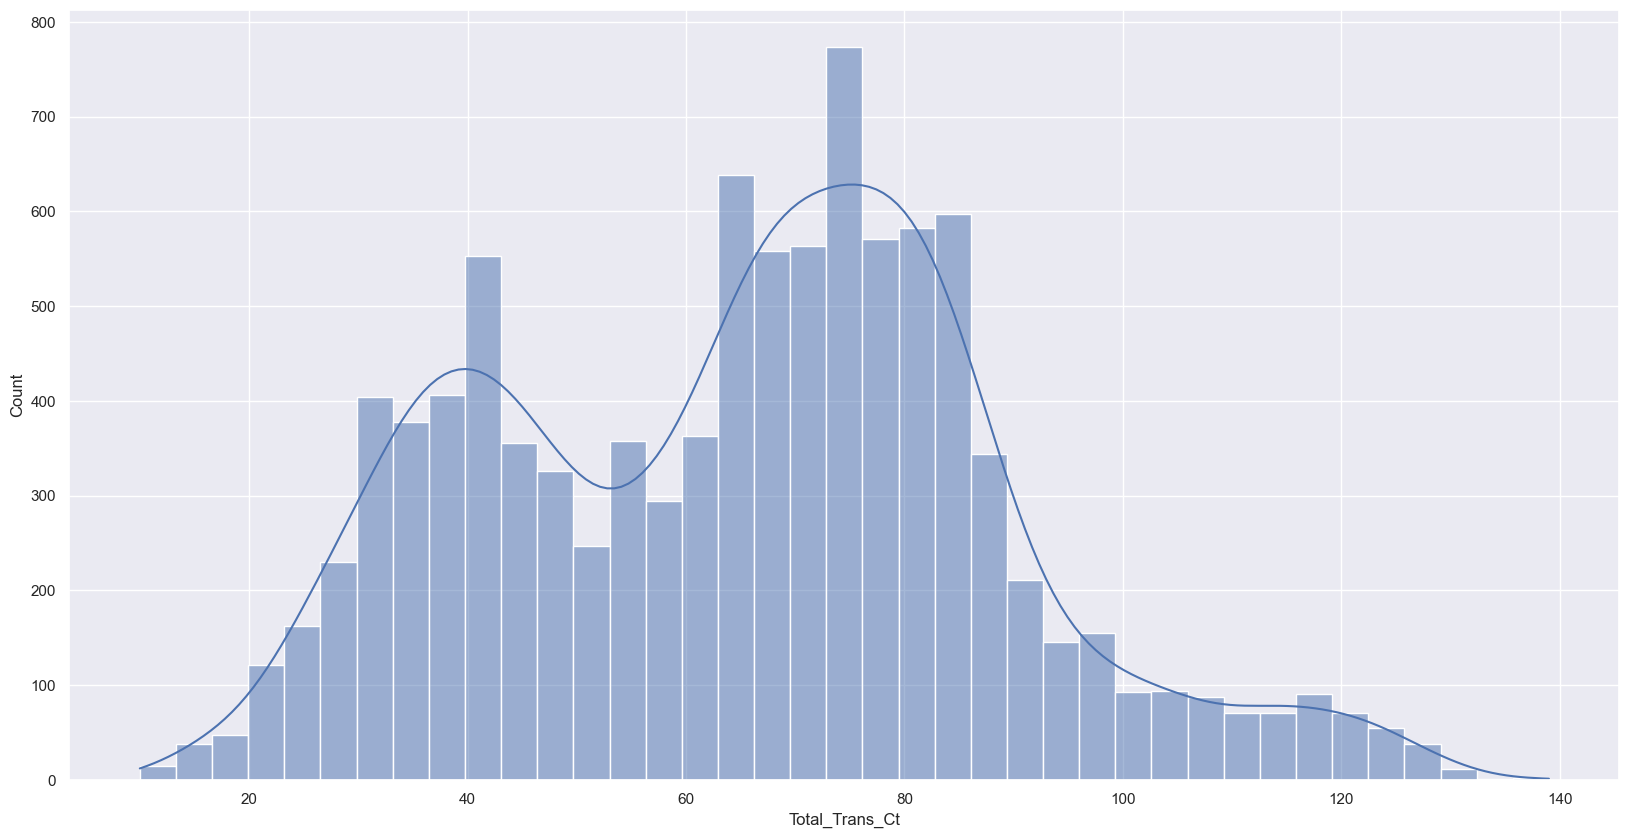

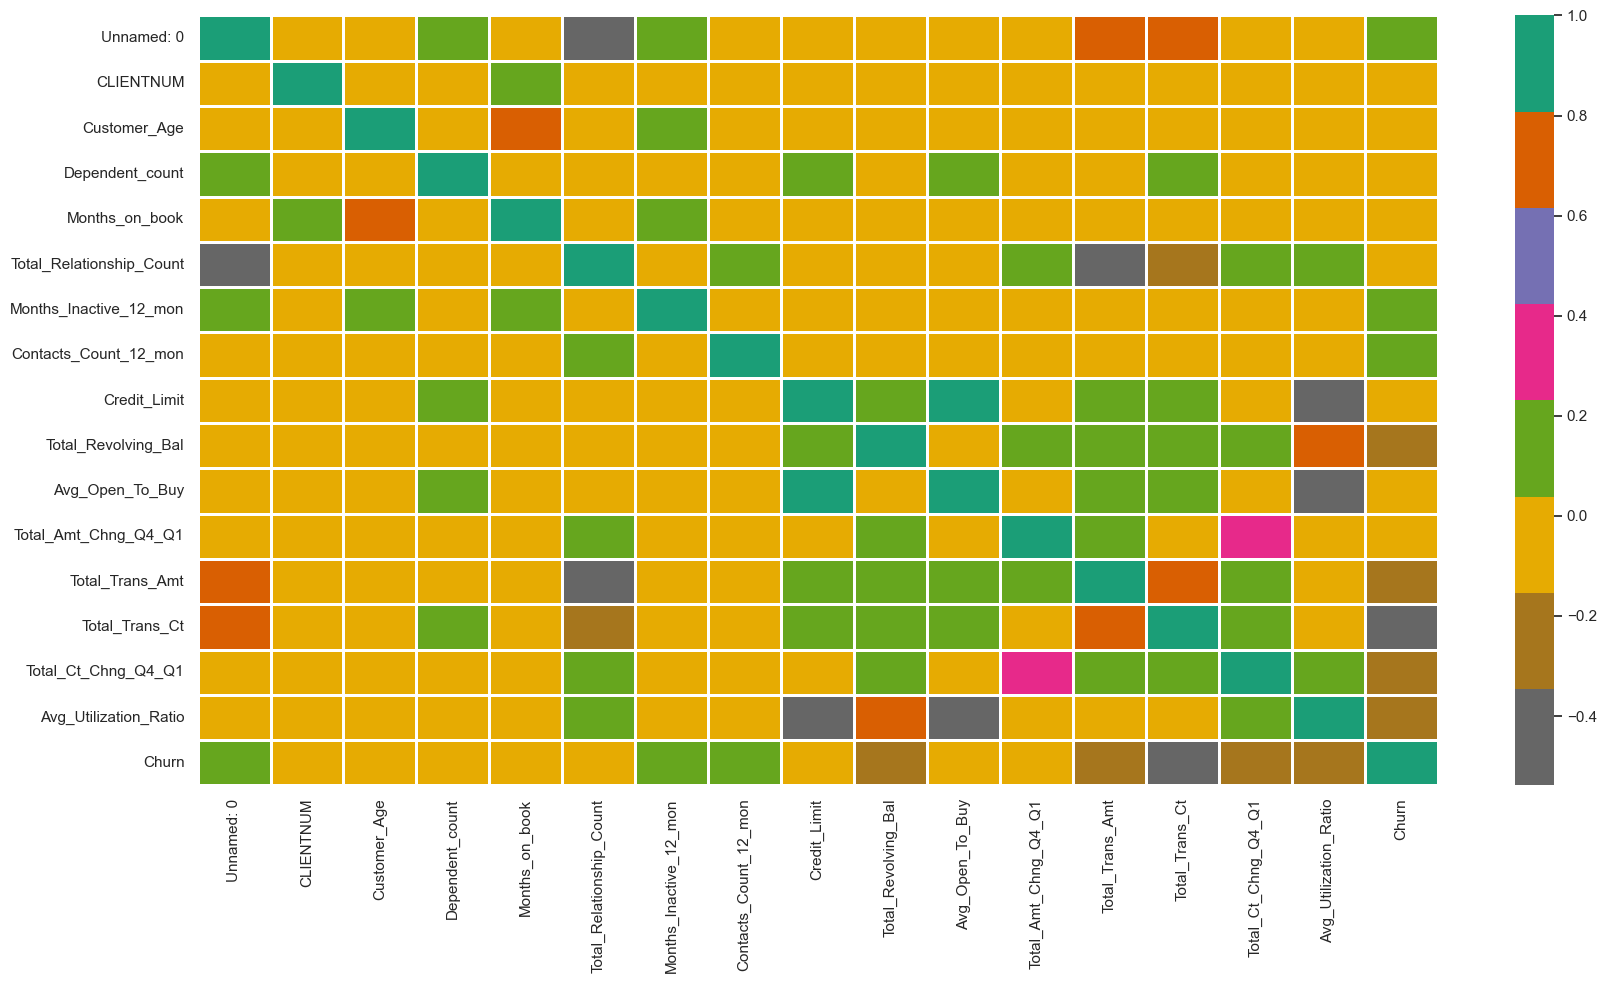

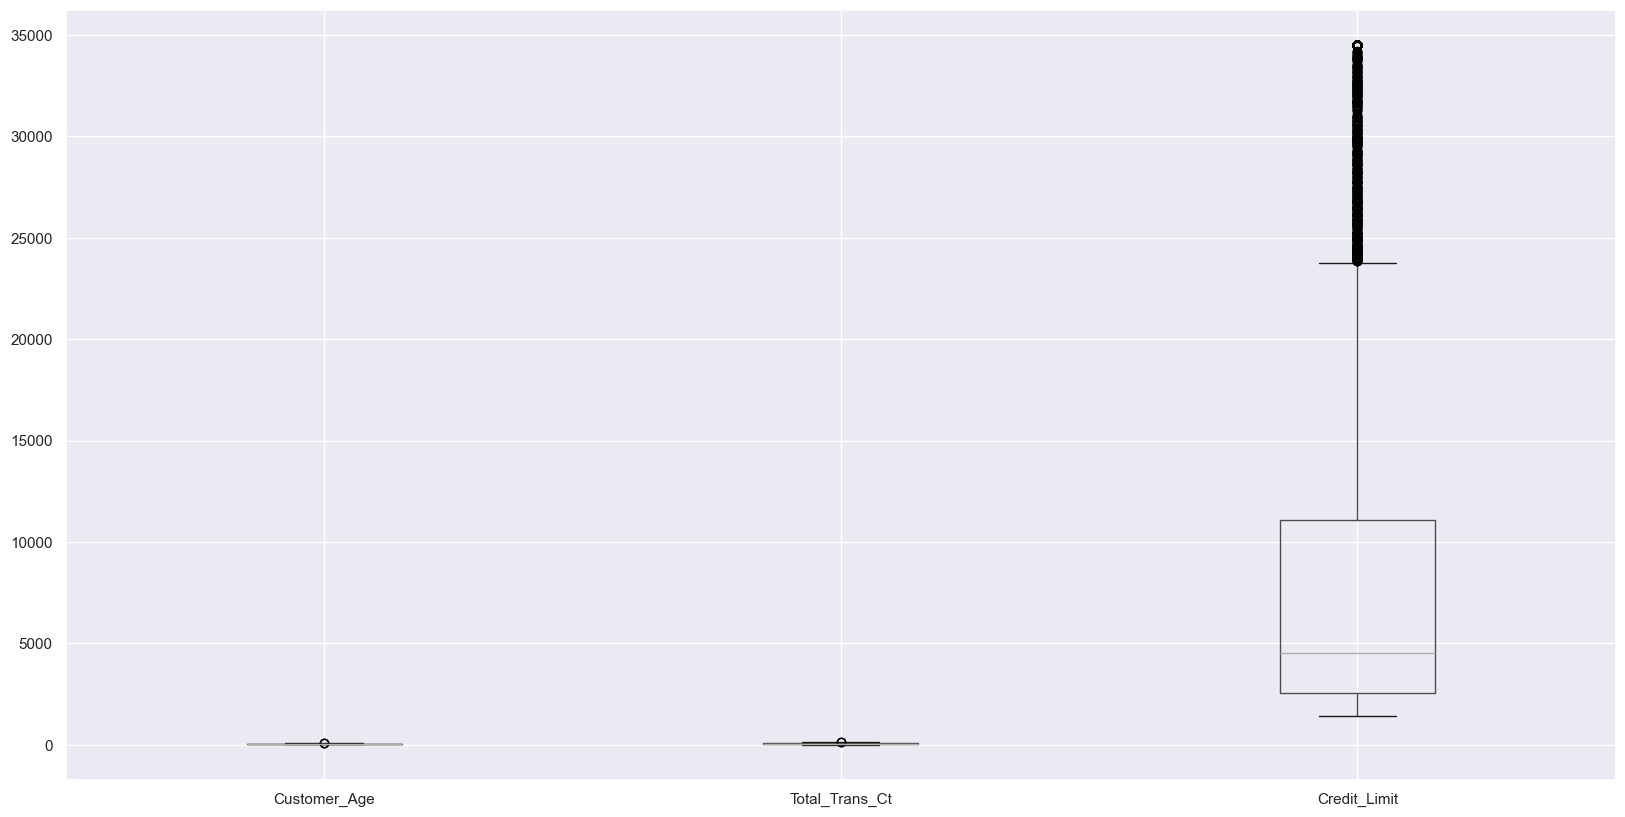

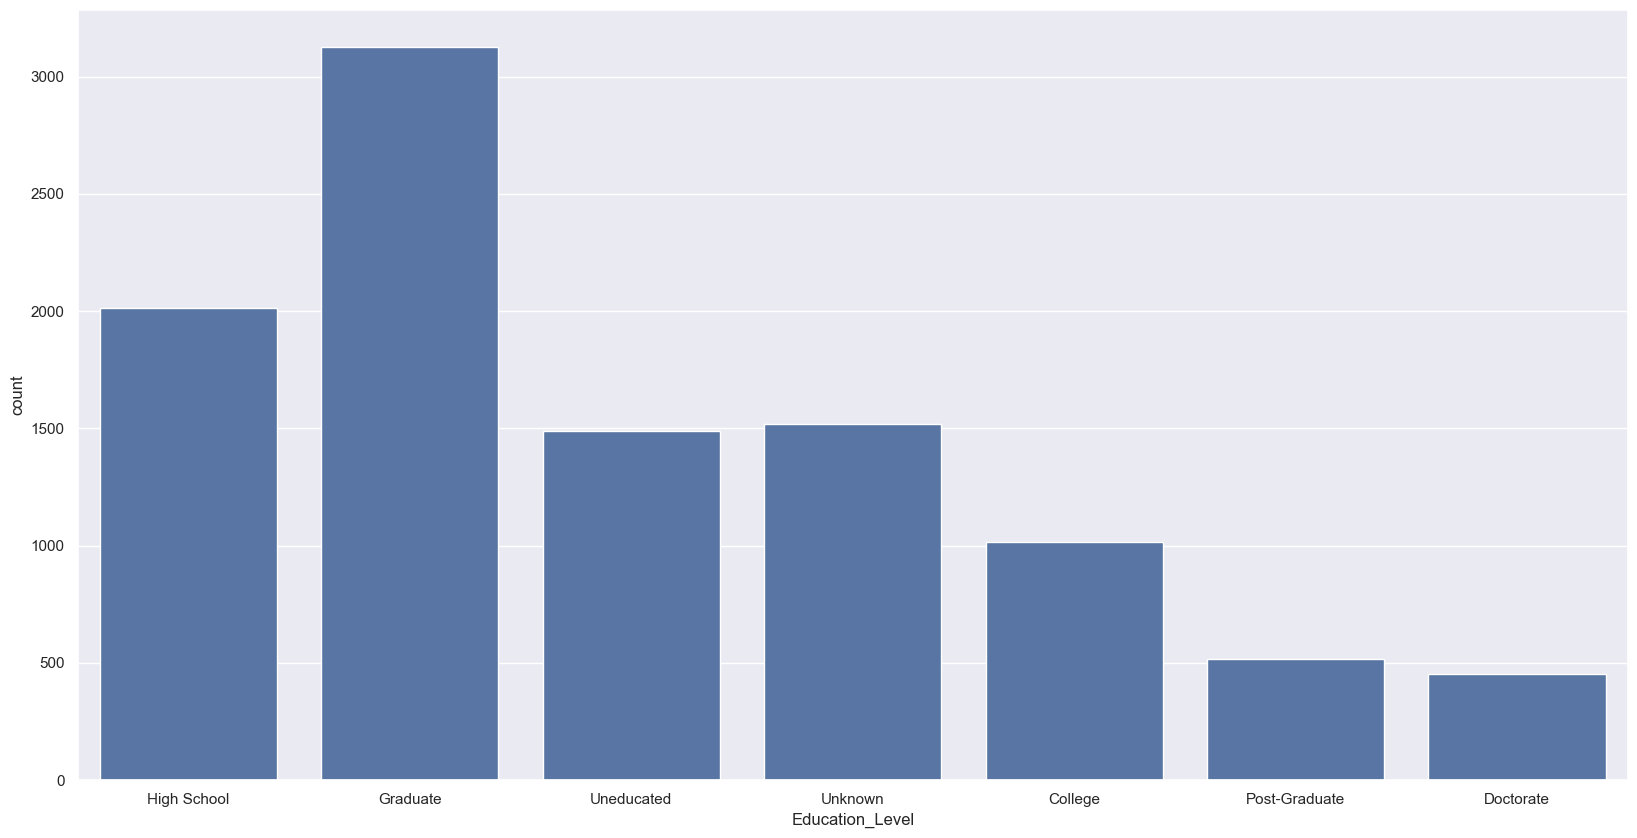

<Figure size 2000x2000 with 0 Axes>

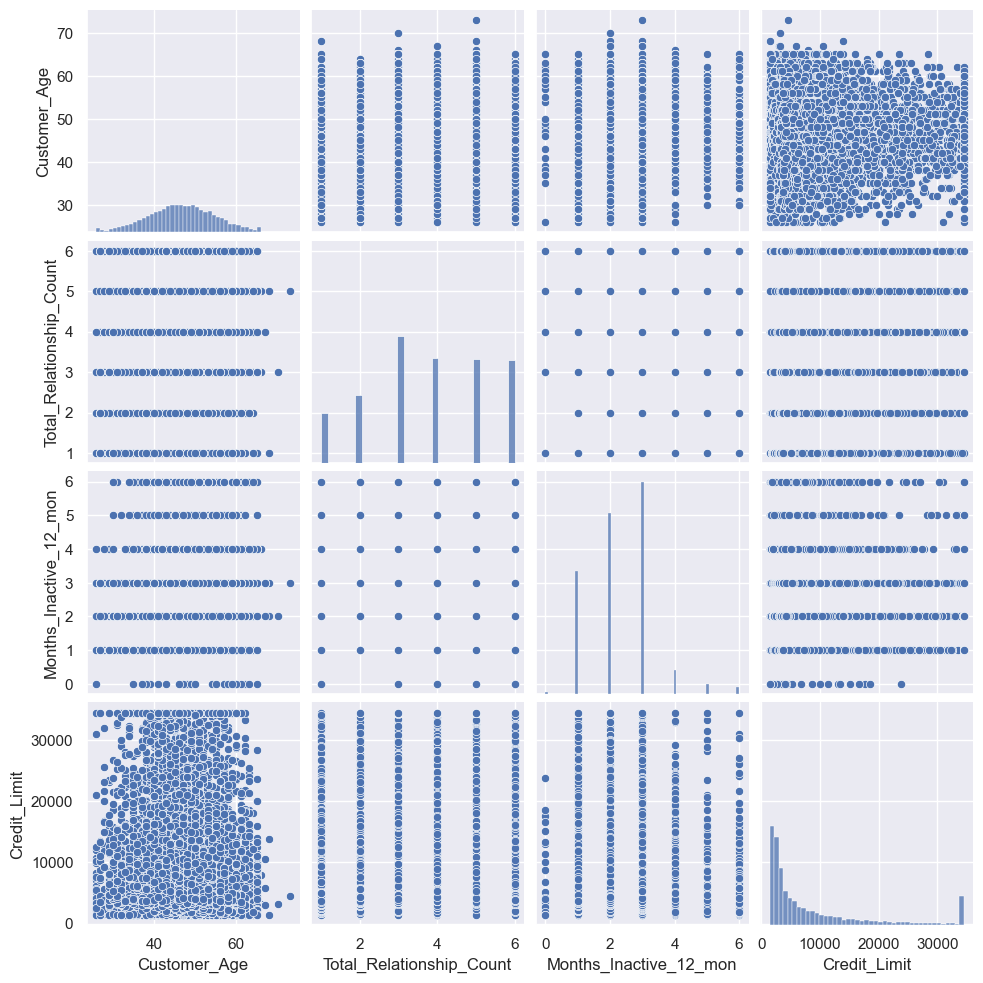

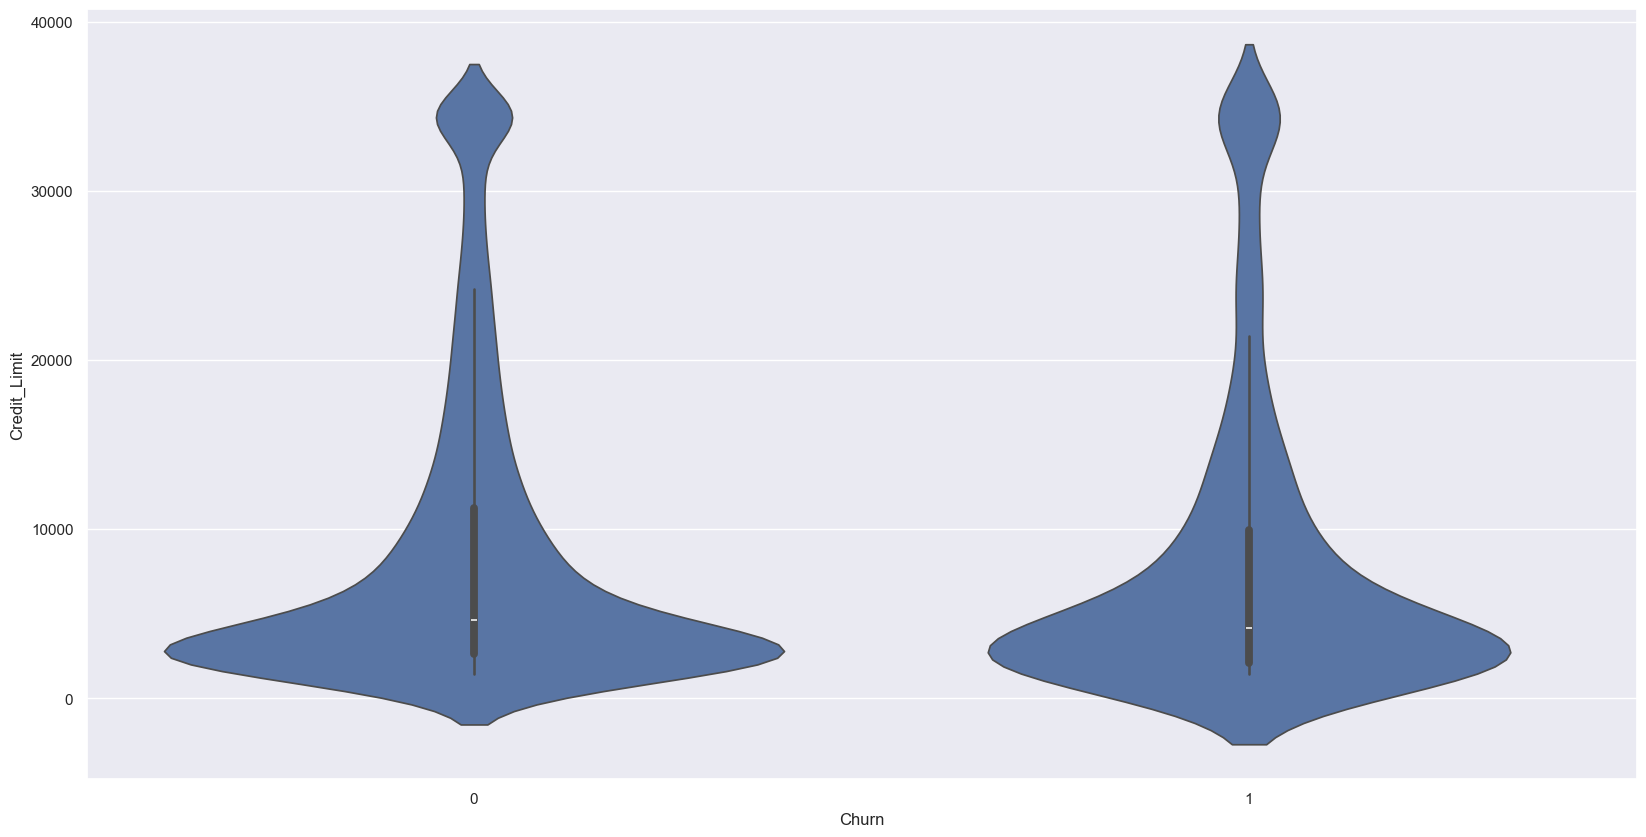

In [23]:

perform_eda(df)

In [24]:

# Step 2: Encoding and Feature Engineering
# Encoding categorical features and performing feature engineering
category_lst = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
df = encoder_helper(df, category_lst, 'Churn')
X_train, X_test, y_train, y_test = perform_feature_engineering(df, 'Churn')


In [25]:

# Step 3: Model Training
# Training Random Forest and Logistic Regression models
rfc_model, lrc_model = train_models(X_train, X_test, y_train, y_test)



60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ml_system/Documents/GitHub_usf/dl_recap/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ml_system/Documents/GitHub_usf/dl_recap/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/Users/ml_system/Documents/GitHub_usf/dl_recap/.venv/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Users/ml_system/Documents/Git

FileNotFoundError: [Errno 2] No such file or directory: 'images/rfc_classification_report.png'

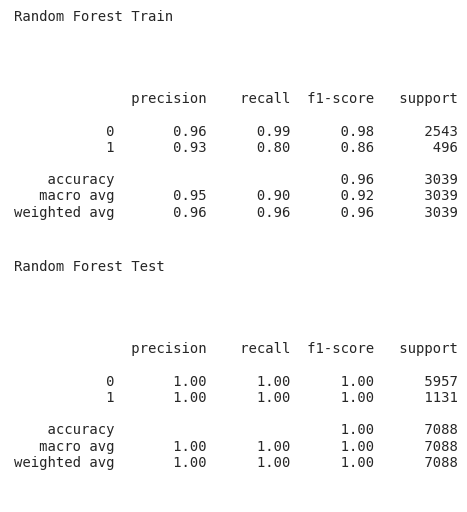

In [26]:
# Step 4: Generating and Saving Classification Reports and ROC Curves
classification_report_image(rfc_model, lrc_model, X_train, X_test, y_train, y_test)


In [32]:
# Step 5: Generating and Saving Feature Importance Plot
BASE_OUTPUT_PATH = 'images/feature_importance'
feature_importance_plot(rfc_model, X_train, BASE_OUTPUT_PATH)
